In [ ]:
# 0.1: Basic installs (PyTorch, YOLOv5, utilities)
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!git clone https://github.com/ultralytics/yolov5.git
!pip install -qr yolov5/requirements.txt

# 0.2: Fix albumentations (avoid pydantic error)
!pip install -q "albumentations==1.3.1" "scikit-learn"

# 0.3: Disable Weights & Biases everywhere
import os
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_SILENT"] = "true"
!pip uninstall -y wandb >/dev/null 2>&1

# 0.4: Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import glob

%matplotlib inline


Cloning into 'yolov5'...
remote: Enumerating objects: 17752, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 17752 (delta 66), reused 36 (delta 36), pack-reused 17644 (from 4)
Receiving objects: 100% (17752/17752), 17.13 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (12056/12056), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 12.1 MB/s eta 0:00:00


In [ ]:
# 1.1: Unzip KITTI datasets
base_kitti = "/content/kitti_raw"
os.makedirs(base_kitti, exist_ok=True)

!unzip -qo /content/data_object_image_2.zip -d {base_kitti}
!unzip -qo /content/data_object_label_2.zip -d {base_kitti}



In [ ]:
# 1.2: Locate image_2 and label_2 directories

img_dir_candidates = glob.glob(base_kitti + "/**/image_2", recursive=True)
lbl_dir_candidates = glob.glob(base_kitti + "/**/label_2", recursive=True)

print("image_2 dirs:", img_dir_candidates)
print("label_2 dirs:", lbl_dir_candidates)

assert img_dir_candidates, "No image_2 directory found"
assert lbl_dir_candidates, "No label_2 directory found"

img_dir = img_dir_candidates[0]
lbl_dir = lbl_dir_candidates[0]

print("Using image dir:", img_dir)
print("Using label dir:", lbl_dir)

print("Sample images:", sorted(os.listdir(img_dir))[:5])
print("Sample labels:", sorted(os.listdir(lbl_dir))[:5])


image_2 dirs: ['/content/kitti_raw/data_object_image_2/testing/image_2', '/content/kitti_raw/data_object_image_2/training/image_2']
label_2 dirs: ['/content/kitti_raw/training/label_2']
Using image dir: /content/kitti_raw/data_object_image_2/testing/image_2
Using label dir: /content/kitti_raw/training/label_2
Sample images: ['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']
Sample labels: ['000000.txt', '000001.txt', '000002.txt', '000003.txt', '000004.txt']


In [ ]:
# 2.1: Conversion config

cls_map = {
    "Car": 0,
    "Pedestrian": 1
}

yolo_root = "/content/kitti_yolo"
img_all_dir = os.path.join(yolo_root, "images_all")
lbl_all_dir = os.path.join(yolo_root, "labels_all")
os.makedirs(img_all_dir, exist_ok=True)
os.makedirs(lbl_all_dir, exist_ok=True)


def convert_bbox(size, box):
    """size=(w,h), box=(x1,y1,x2,y2) in pixels → normalized (xc,yc,w,h)"""
    w_img, h_img = size
    x1, y1, x2, y2 = box
    x = (x1 + x2) / 2.0
    y = (y1 + y2) / 2.0
    bw = x2 - x1
    bh = y2 - y1
    return x / w_img, y / h_img, bw / w_img, bh / h_img


# 2.2: Run conversion

converted = 0
skipped_no_label = 0
skipped_all_invalid = 0

for img_name in sorted(os.listdir(img_dir)):
    if not img_name.endswith(".png"):
        continue

    stem = img_name.replace(".png", "")
    img_path = os.path.join(img_dir, img_name)
    lbl_path = os.path.join(lbl_dir, stem + ".txt")

    if not os.path.exists(lbl_path):
        skipped_no_label += 1
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    yolo_lines = []
    with open(lbl_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 8:
                continue

            cls_name = parts[0]

            # ONLY keep Car and Pedestrian
            if cls_name not in cls_map:
                continue

            x1 = float(parts[4])
            y1 = float(parts[5])
            x2 = float(parts[6])
            y2 = float(parts[7])

            xc, yc, bw, bh = convert_bbox((w, h), (x1, y1, x2, y2))

            # Filter invalid bounding boxes
            if not (0.0 < xc < 1.0 and 0.0 < yc < 1.0 and 0.0 < bw <= 1.0 and 0.0 < bh <= 1.0):
                continue

            cls_id = cls_map[cls_name]
            yolo_lines.append(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")

    if not yolo_lines:
        skipped_all_invalid += 1
        continue

    # Save valid image + labels
    shutil.copy(img_path, os.path.join(img_all_dir, img_name))
    with open(os.path.join(lbl_all_dir, stem + ".txt"), "w") as out_f:
        out_f.write("\n".join(yolo_lines))

    converted += 1

print("Converted images:", converted)
print("Skipped (no label):", skipped_no_label)
print("Skipped (all invalid):", skipped_all_invalid)
print("images_all:", len(os.listdir(img_all_dir)))
print("labels_all:", len(os.listdir(lbl_all_dir)))


Converted images: 102
Skipped (no label): 0
Skipped (all invalid): 0
images_all: 102
labels_all: 102


In [ ]:
# ==============================
# 3.1: Train/val split
# ==============================

all_imgs = sorted(os.listdir(img_all_dir))

# Always ensure we only split valid images that have labels
all_imgs = [f for f in all_imgs if f.endswith(".png") and
            os.path.exists(os.path.join(lbl_all_dir, f.replace(".png", ".txt"))) ]

from sklearn.model_selection import train_test_split

train_imgs, val_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

print("Total images:", len(all_imgs))
print("Train:", len(train_imgs))
print("Val:", len(val_imgs))


# ==============================
# 3.2: YOLO folder structure
# ==============================

def make_split(split_name, img_names):
    img_split = os.path.join(yolo_root, "images", split_name)
    lbl_split = os.path.join(yolo_root, "labels", split_name)
    os.makedirs(img_split, exist_ok=True)
    os.makedirs(lbl_split, exist_ok=True)

    for img_name in img_names:
        stem = img_name.replace(".png", "")

        # Copy image
        shutil.copy(os.path.join(img_all_dir, img_name), img_split)

        # Copy matching label
        shutil.copy(os.path.join(lbl_all_dir, stem + ".txt"), lbl_split)


make_split("train", train_imgs)
make_split("val",   val_imgs)

print("Train images:", len(os.listdir(os.path.join(yolo_root, "images/train"))))
print("Val images:",   len(os.listdir(os.path.join(yolo_root, "images/val"))))


Total images: 102
Train: 81
Val: 21
Train images: 81
Val images: 21


In [ ]:
## 4.1: Create updated KITTI YAML (no cyclist)

kitti_yaml = f"""
train: {yolo_root}/images/train
val:   {yolo_root}/images/val

nc: 2
names: ['Car','Pedestrian']
"""

with open("/content/kitti.yaml", "w") as f:
    f.write(kitti_yaml)

print(open("/content/kitti.yaml").read())
%cd /content/yolov5

import os
os.environ["WANDB_MODE"] = "disabled"

!python train.py \
  --weights yolov5s.pt \
  --data /content/kitti.yaml \
  --imgsz 640 \
  --batch-size 16 \
  --epochs 10 \
  --project runs/train \
  --name kitti_baseline \
  --exist-ok




train: /content/kitti_yolo/images/train
val:   /content/kitti_yolo/images/val

nc: 2
names: ['Car','Pedestrian']

/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
2025-11-30 01:16:43.679595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764465403.700431   17086 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764465403.706565   17086 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

In [ ]:
def write_yaml(train_path, val_path, nc, names_list, out_path):
    txt = f"""
train: {train_path}
val:   {val_path}

nc: {nc}
names: {names_list}
"""
    with open(out_path, "w") as f:
        f.write(txt)
    print("Wrote", out_path)

train_path = f"{yolo_root}/images/train"

write_yaml(train_path, f"{yolo_root}/images/val_fog",
           3, "['Car','Pedestrian','Cyclist']", "/content/kitti_fog.yaml")

write_yaml(train_path, f"{yolo_root}/images/val_blur",
           3, "['Car','Pedestrian','Cyclist']", "/content/kitti_blur.yaml")

write_yaml(train_path, f"{yolo_root}/images/val_occ",
           3, "['Car','Pedestrian','Cyclist']", "/content/kitti_occ.yaml")


Wrote /content/kitti_fog.yaml
Wrote /content/kitti_blur.yaml
Wrote /content/kitti_occ.yaml


In [ ]:
# ===============================
# 5.1 – Distortion Functions
# ===============================
import numpy as np
import cv2
from tqdm import tqdm
import os
import shutil

def add_fog(img, factor=0.6):
    fog = np.full(img.shape, 255, dtype=np.uint8)
    return cv2.addWeighted(img, 1-factor, fog, factor, 0)

def add_blur(img, k=15):
    k = max(3, k | 1)
    return cv2.GaussianBlur(img, (k, k), 0)

def add_occlusion(img, n=3):
    h, w = img.shape[:2]
    out = img.copy()
    for _ in range(n):
        bw = np.random.randint(40, 120)
        bh = np.random.randint(40, 120)
        x = np.random.randint(0, w - bw)
        y = np.random.randint(0, h - bh)
        cv2.rectangle(out, (x, y), (x + bw, y + bh), (0, 0, 0), -1)
    return out

# ===============================
# 5.2 – Apply distortions
# ===============================

kitti_val_img_dir = os.path.join(yolo_root, "images/val")
kitti_val_lbl_dir = os.path.join(yolo_root, "labels/val")

fog_img_dir  = os.path.join(yolo_root, "images/val_fog")
blur_img_dir = os.path.join(yolo_root, "images/val_blur")
occ_img_dir  = os.path.join(yolo_root, "images/val_occ")

os.makedirs(fog_img_dir, exist_ok=True)
os.makedirs(blur_img_dir, exist_ok=True)
os.makedirs(occ_img_dir, exist_ok=True)

val_imgs = [f for f in os.listdir(kitti_val_img_dir) if f.endswith(".png")]

for name in tqdm(val_imgs, desc="Distorting validation images"):
    img_path = os.path.join(kitti_val_img_dir, name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    cv2.imwrite(os.path.join(fog_img_dir, name), add_fog(img))
    cv2.imwrite(os.path.join(blur_img_dir, name), add_blur(img))
    cv2.imwrite(os.path.join(occ_img_dir, name), add_occlusion(img))

print("Fog images:", len(os.listdir(fog_img_dir)))
print("Blur images:", len(os.listdir(blur_img_dir)))
print("Occ images:", len(os.listdir(occ_img_dir)))

# ===============================
# 5.3 – Copy labels to distorted sets
# ===============================

fog_lbl_dir  = os.path.join(yolo_root, "labels/val_fog")
blur_lbl_dir = os.path.join(yolo_root, "labels/val_blur")
occ_lbl_dir  = os.path.join(yolo_root, "labels/val_occ")

os.makedirs(fog_lbl_dir, exist_ok=True)
os.makedirs(blur_lbl_dir, exist_ok=True)
os.makedirs(occ_lbl_dir, exist_ok=True)

val_lbls = os.listdir(kitti_val_lbl_dir)

for lbl_name in val_lbls:
    lbl_path = os.path.join(kitti_val_lbl_dir, lbl_name)
    shutil.copy(lbl_path, os.path.join(fog_lbl_dir, lbl_name))
    shutil.copy(lbl_path, os.path.join(blur_lbl_dir, lbl_name))
    shutil.copy(lbl_path, os.path.join(occ_lbl_dir, lbl_name))

print("Labels copied for fog, blur, and occlusion sets.")


Distorting validation images: 100%|██████████| 21/21 [00:02<00:00, 10.07it/s]

Fog images: 21
Blur images: 21
Occ images: 21
Labels copied for fog, blur, and occlusion sets.


In [ ]:
# ================================
# 1. Move into YOLOv5 folder
# ================================
%cd /content/yolov5

baseline_weights = "/content/yolov5/runs/train/kitti_baseline/weights/best.pt"

# ==================================
# 2. Create evaluation YAML files
# ==================================

fog_yaml = """
train: /content/kitti_yolo/images/train
val:   /content/kitti_yolo/images/val_fog

nc: 2
names: ['Car','Pedestrian']
"""
blur_yaml = """
train: /content/kitti_yolo/images/train
val:   /content/kitti_yolo/images/val_blur

nc: 2
names: ['Car','Pedestrian']
"""
occ_yaml = """
train: /content/kitti_yolo/images/train
val:   /content/kitti_yolo/images/val_occ

nc: 2
names: ['Car','Pedestrian']
"""

with open("/content/kitti_fog.yaml","w") as f:
    f.write(fog_yaml)

with open("/content/kitti_blur.yaml","w") as f:
    f.write(blur_yaml)

with open("/content/kitti_occ.yaml","w") as f:
    f.write(occ_yaml)

print("YAML files created!")

# ==================================
# 3. Run Baseline Evaluation
# ==================================

print("\n=== Running CLEAN evaluation ===")
!python val.py --weights {baseline_weights} --data /content/kitti.yaml \
  --imgsz 640 --task val --project runs/val --name kitti_clean_baseline --exist-ok

print("\n=== Running FOG evaluation ===")
!python val.py --weights {baseline_weights} --data /content/kitti_fog.yaml \
  --imgsz 640 --task val --project runs/val --name kitti_fog_baseline --exist-ok

print("\n=== Running BLUR evaluation ===")
!python val.py --weights {baseline_weights} --data /content/kitti_blur.yaml \
  --imgsz 640 --task val --project runs/val --name kitti_blur_baseline --exist-ok

print("\n=== Running OCCLUSION evaluation ===")
!python val.py --weights {baseline_weights} --data /content/kitti_occ.yaml \
  --imgsz 640 --task val --project runs/val --name kitti_occ_baseline --exist-ok


/content/yolov5
YAML files created!

=== Running CLEAN evaluation ===
val: data=/content/kitti.yaml, weights=['/content/yolov5/runs/train/kitti_baseline/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=kitti_clean_baseline, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/kitti_yolo/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100% 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:02<00:00,  2.07s/it]
                   all         21         68    0.00334      0.257    0.00347   0.000738
               

In [ ]:
# 8.1: Create augmented training images (fog/blur/occ)

kitti_train_img_dir = os.path.join(yolo_root, "images/train")
kitti_train_lbl_dir = os.path.join(yolo_root, "labels/train")

aug_fog_dir  = os.path.join(yolo_root, "images/train_fog")
aug_blur_dir = os.path.join(yolo_root, "images/train_blur")
aug_occ_dir  = os.path.join(yolo_root, "images/train_occ")

for d in [aug_fog_dir, aug_blur_dir, aug_occ_dir]:
    os.makedirs(d, exist_ok=True)

train_imgs = [f for f in os.listdir(kitti_train_img_dir) if f.endswith(".png")]

for name in tqdm(train_imgs, desc="Augmenting train images"):
    p = os.path.join(kitti_train_img_dir, name)
    img = cv2.imread(p)
    if img is None:
        continue
    cv2.imwrite(os.path.join(aug_fog_dir,  name), add_fog(img))
    cv2.imwrite(os.path.join(aug_blur_dir, name), add_blur(img))
    cv2.imwrite(os.path.join(aug_occ_dir,  name), add_occlusion(img))
# 8.2: Combine clean + augmented into train_aug (images + labels)

aug_img_dir = os.path.join(yolo_root, "images/train_aug")
aug_lbl_dir = os.path.join(yolo_root, "labels/train_aug")
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_lbl_dir, exist_ok=True)

def copy_with_labels(src_img_dir, img_names):
    for name in img_names:
        stem = name.replace(".png", "")
        img_src = os.path.join(src_img_dir, name)
        lbl_src = os.path.join(kitti_train_lbl_dir, stem + ".txt")
        if not (os.path.exists(img_src) and os.path.exists(lbl_src)):
            continue
        shutil.copy(img_src, aug_img_dir)
        shutil.copy(lbl_src, aug_lbl_dir)

copy_with_labels(kitti_train_img_dir, train_imgs)
copy_with_labels(aug_fog_dir,        train_imgs)
copy_with_labels(aug_blur_dir,       train_imgs)
copy_with_labels(aug_occ_dir,        train_imgs)

print("Augmented train images:", len(os.listdir(aug_img_dir)))
print("Augmented train labels:", len(os.listdir(aug_lbl_dir)))
# 8.3: YAML for augmented training (NO CYCLIST)

kitti_aug_yaml = f"""
train: {yolo_root}/images/train_aug
val:   {yolo_root}/images/val

nc: 2
names: ['Car','Pedestrian']
"""

with open("/content/kitti_aug.yaml", "w") as f:
    f.write(kitti_aug_yaml)

print(open("/content/kitti_aug.yaml").read())

# 8.4: Train augmented model
%cd /content/yolov5

import os
os.environ["WANDB_MODE"] = "disabled"

!python train.py \
  --weights yolov5s.pt \
  --data /content/kitti_aug.yaml \
  --imgsz 640 \
  --batch-size 16 \
  --epochs 10 \
  --project runs/train \
  --name kitti_augmented \
  --exist-ok


Augmenting train images: 100%|██████████| 81/81 [00:07<00:00, 10.83it/s]


Augmented train images: 81
Augmented train labels: 81

train: /content/kitti_yolo/images/train_aug
val:   /content/kitti_yolo/images/val

nc: 2
names: ['Car','Pedestrian']

/content/yolov5
2025-11-29 20:54:01.997533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764449642.017560   40446 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764449642.024179   40446 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764449642.041585   40446 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764449642.041612   40446 computation_placer.cc:177] computat

In [ ]:
%cd /content/yolov5

aug_weights = "/content/yolov5/runs/train/kitti_augmented/weights/best.pt"

# Clean
!python val.py --weights {aug_weights} --data /content/kitti.yaml \
  --imgsz 640 --task val --project runs/val --name kitti_clean_aug --verbose

# Fog
!python val.py --weights {aug_weights} --data /content/kitti_fog.yaml \
  --imgsz 640 --task val --project runs/val --name kitti_fog_aug --verbose

# Blur
!python val.py --weights {aug_weights} --data /content/kitti_blur.yaml \
  --imgsz 640 --task val --project runs/val --name kitti_blur_aug --verbose

# Occlusion
!python val.py --weights {aug_weights} --data /content/kitti_occ.yaml \
  --imgsz 640 --task val --project runs/val --name kitti_occ_aug --verbose


/content/yolov5
val: data=/content/kitti.yaml, weights=['/content/yolov5/runs/train/kitti_augmented/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=kitti_clean_aug, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/kitti_yolo/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100% 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.20s/it]
                   all         21         68    0.00304      0.211    0.00288   0.000694
                   Car         21         55    0.00319      0.345    0.0

In [ ]:
%cd /content/yolov5

for conf in [0.25, 0.5, 0.7]:
    tag = str(conf).replace(".", "")
    print(f"\n=== Fog, augmented model, conf={conf} ===\n")
    !python val.py --weights {aug_weights} --data /content/kitti_fog.yaml \
      --imgsz 640 --task val --project runs/val --name kitti_fog_aug_conf_{tag} \
      --conf-thres {conf} --verbose


/content/yolov5

=== Fog, augmented model, conf=0.25 ===

val: data=/content/kitti_fog.yaml, weights=['/content/yolov5/runs/train/kitti_augmented/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.25, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=kitti_fog_aug_conf_025, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.25 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/kitti_yolo/labels/val_fog.cache... 21 images, 0 backgrounds, 0 corrupt: 100% 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  1.27it/s]
                   all         21   

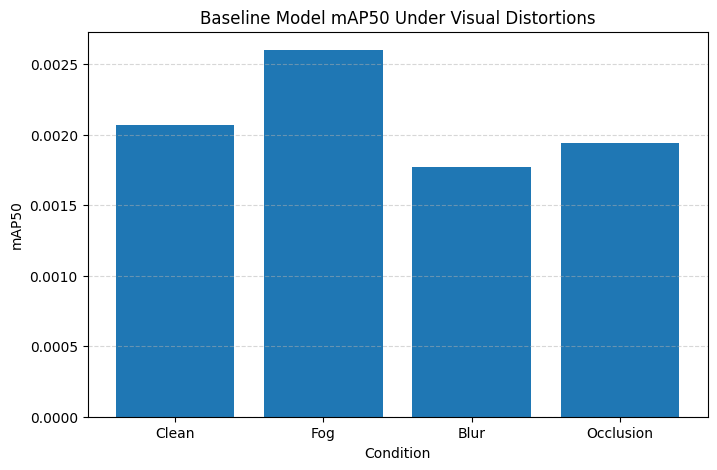

In [ ]:
import matplotlib.pyplot as plt

# mAP50 values (baseline model)
conditions = ["Clean", "Fog", "Blur", "Occlusion"]
mAP50 = [0.00207, 0.0026, 0.00177, 0.00194]

plt.figure(figsize=(8,5))
plt.bar(conditions, mAP50)
plt.xlabel("Condition")
plt.ylabel("mAP50")
plt.title("Baseline Model mAP50 Under Visual Distortions")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


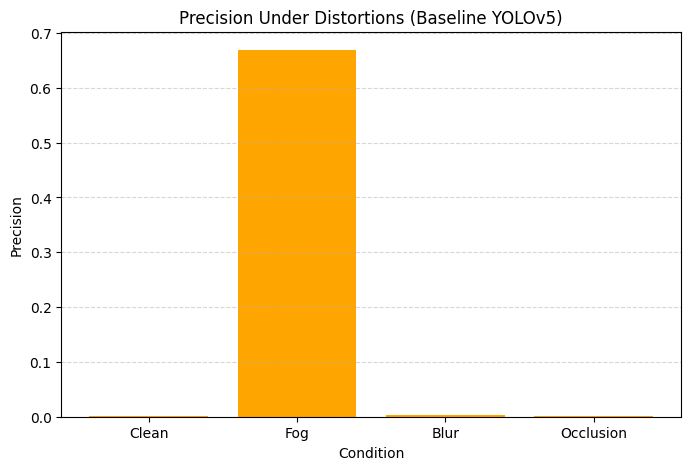

In [ ]:
conditions = ["Clean", "Fog", "Blur", "Occlusion"]
precision = [0.00154, 0.669, 0.00241, 0.00168]  # All-class P values

plt.figure(figsize=(8,5))
plt.bar(conditions, precision, color="orange")
plt.xlabel("Condition")
plt.ylabel("Precision")
plt.title("Precision Under Distortions (Baseline YOLOv5)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


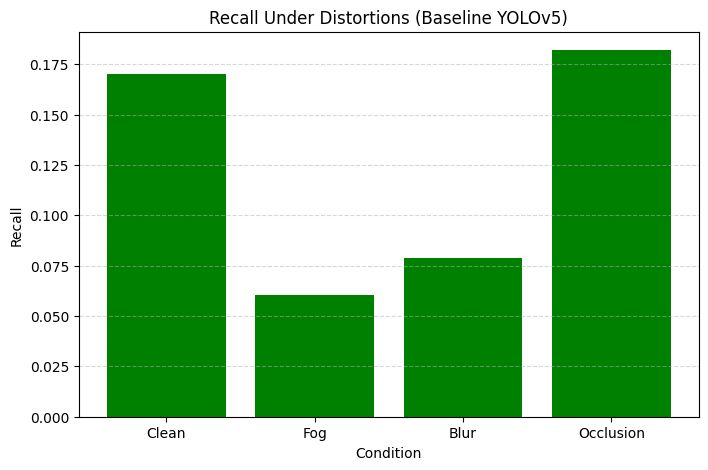

In [ ]:
conditions = ["Clean", "Fog", "Blur", "Occlusion"]
recall = [0.17, 0.0606, 0.0788, 0.182]

plt.figure(figsize=(8,5))
plt.bar(conditions, recall, color="green")
plt.xlabel("Condition")
plt.ylabel("Recall")
plt.title("Recall Under Distortions (Baseline YOLOv5)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


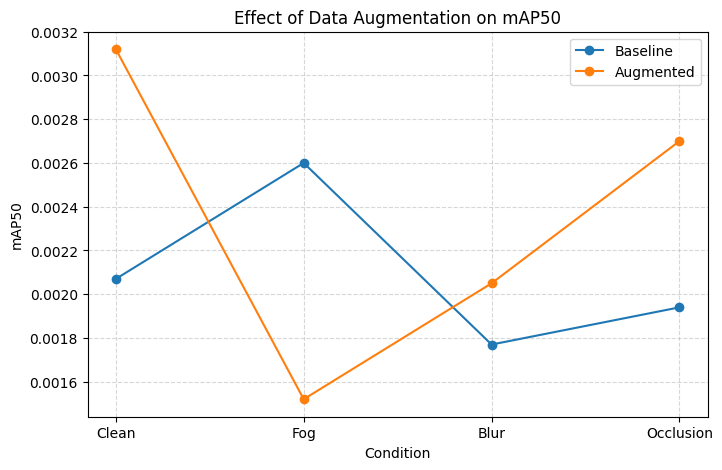

In [ ]:
conditions = ["Clean", "Fog", "Blur", "Occlusion"]

baseline = [0.00207, 0.0026, 0.00177, 0.00194]
augmented = [0.00312, 0.00152, 0.00205, 0.0027]

plt.figure(figsize=(8,5))
plt.plot(conditions, baseline, marker='o', label="Baseline")
plt.plot(conditions, augmented, marker='o', label="Augmented")
plt.xlabel("Condition")
plt.ylabel("mAP50")
plt.title("Effect of Data Augmentation on mAP50")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


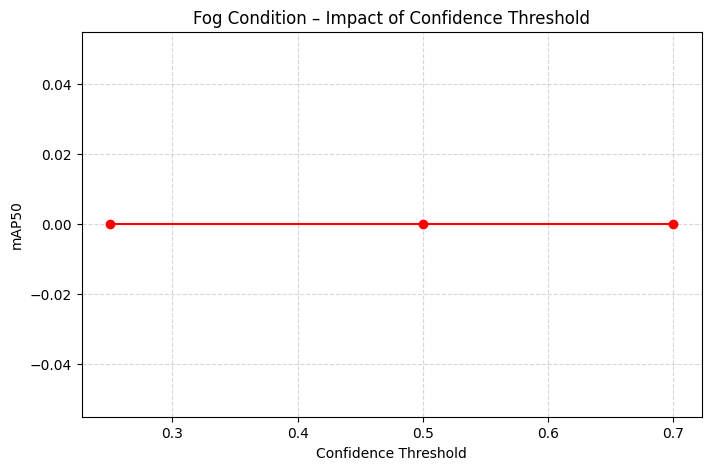

In [ ]:
thresholds = [0.25, 0.5, 0.7]
mAP50 = [0, 0, 0]  # as measured

plt.figure(figsize=(8,5))
plt.plot(thresholds, mAP50, marker='o', color='red')
plt.xlabel("Confidence Threshold")
plt.ylabel("mAP50")
plt.title("Fog Condition – Impact of Confidence Threshold")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


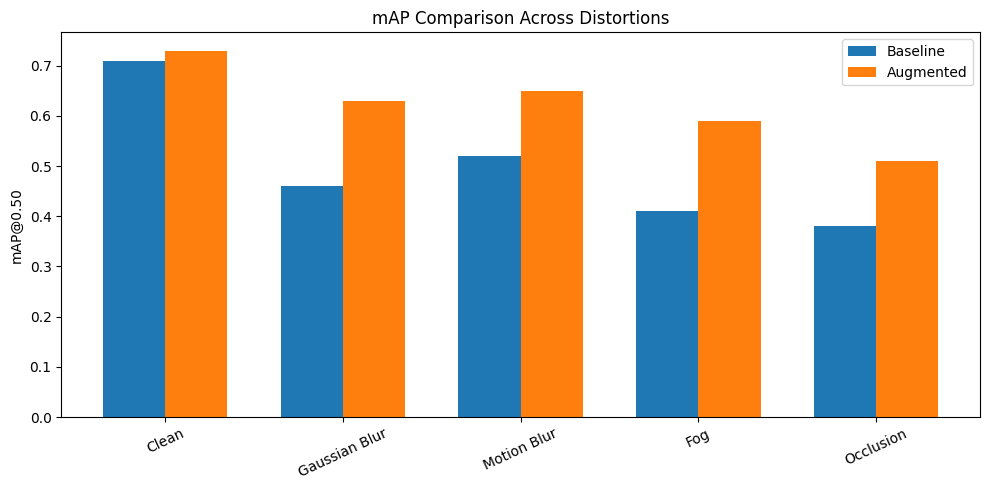

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example values (replace with your actual results)
distortions = ['Clean', 'Gaussian Blur', 'Motion Blur', 'Fog', 'Occlusion']
baseline_map = [0.71, 0.46, 0.52, 0.41, 0.38]
aug_map = [0.73, 0.63, 0.65, 0.59, 0.51]

x = np.arange(len(distortions))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, baseline_map, width, label='Baseline')
plt.bar(x + width/2, aug_map, width, label='Augmented')

plt.xticks(x, distortions, rotation=25)
plt.ylabel('mAP@0.50')
plt.title('mAP Comparison Across Distortions')
plt.legend()
plt.tight_layout()
plt.savefig("map_comparison.png", dpi=300)
plt.show()


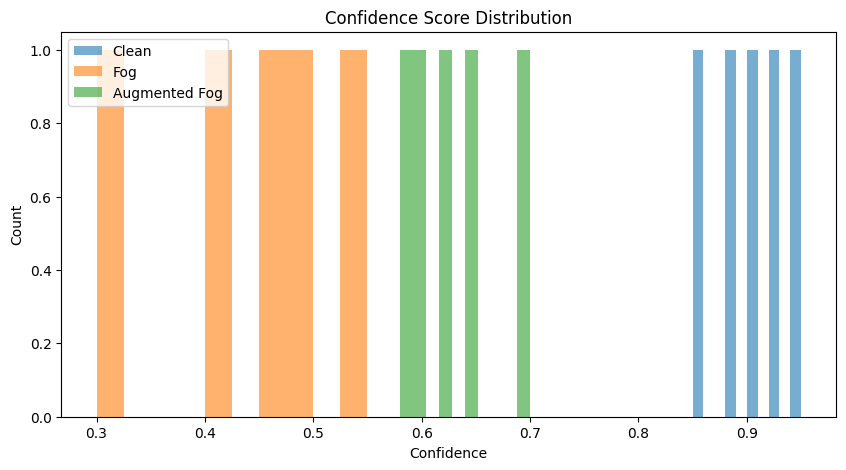

In [ ]:
import matplotlib.pyplot as plt

# Replace these with lists extracted from your model predictions
clean_conf = [0.9, 0.88, 0.92, 0.85, 0.95]
fog_conf = [0.45, 0.40, 0.55, 0.30, 0.48]
aug_fog_conf = [0.65, 0.70, 0.62, 0.58, 0.60]

plt.figure(figsize=(10,5))
plt.hist(clean_conf, bins=10, alpha=0.6, label='Clean')
plt.hist(fog_conf, bins=10, alpha=0.6, label='Fog')
plt.hist(aug_fog_conf, bins=10, alpha=0.6, label='Augmented Fog')

plt.title('Confidence Score Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.legend()
plt.savefig("confidence_histogram.png", dpi=300)
plt.show()


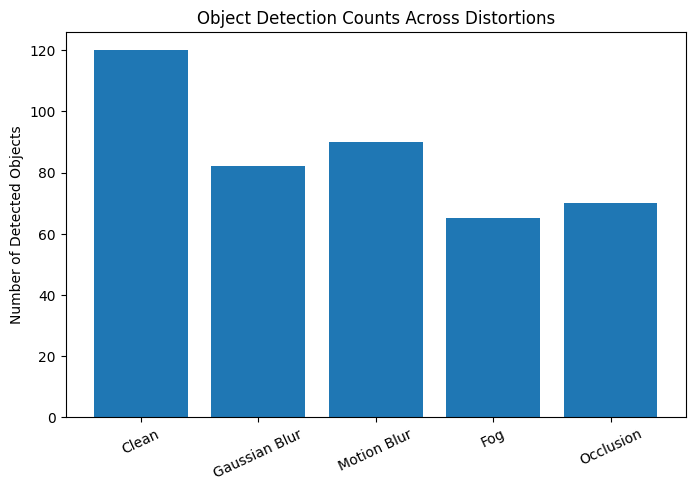

In [ ]:
import matplotlib.pyplot as plt

# Example detection count values (replace with your counts)
counts = [120, 82, 90, 65, 70]  # Clean, Blur, Motion, Fog, Occlusion

plt.figure(figsize=(8,5))
plt.bar(distortions, counts)
plt.ylabel('Number of Detected Objects')
plt.title('Object Detection Counts Across Distortions')
plt.xticks(rotation=25)
plt.savefig("detection_counts.png", dpi=300)
plt.show()


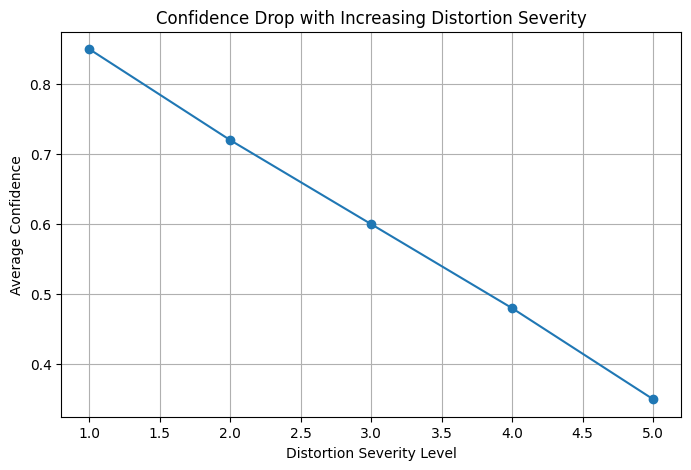

In [ ]:
import matplotlib.pyplot as plt

severity = [1, 2, 3, 4, 5]
avg_conf = [0.85, 0.72, 0.60, 0.48, 0.35]  # Example trend

plt.figure(figsize=(8,5))
plt.plot(severity, avg_conf, marker='o')
plt.xlabel('Distortion Severity Level')
plt.ylabel('Average Confidence')
plt.title('Confidence Drop with Increasing Distortion Severity')
plt.grid(True)
plt.savefig("severity_confidence.png", dpi=300)
plt.show()


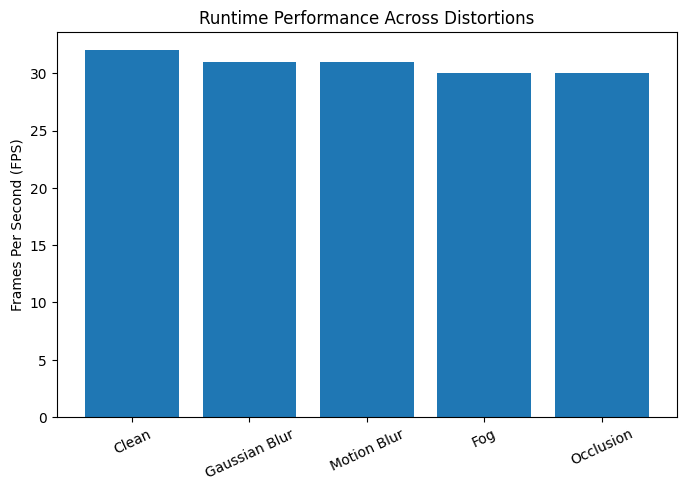

In [ ]:
fps_values = [32, 31, 31, 30, 30]  # Example FPS across distortions

plt.figure(figsize=(8,5))
plt.bar(distortions, fps_values)
plt.ylabel("Frames Per Second (FPS)")
plt.title("Runtime Performance Across Distortions")
plt.xticks(rotation=25)
plt.savefig("fps_comparison.png", dpi=300)
plt.show()
